<a href="https://colab.research.google.com/github/sai-teja-ponugoti/Face-Mask-Detection/blob/main/dev%20jupyter%20notebooks/dev_train_mask_detctor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# dataset is stored in google drive, so mounting the drive
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/dataset

Mounted at /content/drive


In [6]:
# import the required packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imutils import paths

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [7]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
TRAIN_DATA_DIR = "/content/drive/MyDrive/dataset"
IMG_HEIGHT = IMG_WIDTH = 224
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
EPOCHS = 20

[INFO] loading images...


In [33]:
train_datagen = ImageDataGenerator(rescale=1./255, 
    rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest",
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data


Found 3067 images belonging to 2 classes.
Found 766 images belonging to 2 classes.


In [38]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [39]:
# training the model
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 5)

Epoch 1/5
 2/23 [=>............................] - ETA: 19s - loss: 0.9696 - accuracy: 0.4648

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


23/23 [==============================] - 51s 2s/step - loss: 0.6225 - accuracy: 0.6736 - val_loss: 0.2610 - val_accuracy: 0.9484
Epoch 2/5
23/23 [==============================] - 49s 2s/step - loss: 0.2627 - accuracy: 0.8996 - val_loss: 0.1401 - val_accuracy: 0.9672
Epoch 3/5
23/23 [==============================] - 49s 2s/step - loss: 0.1622 - accuracy: 0.9435 - val_loss: 0.1092 - val_accuracy: 0.9750
Epoch 4/5
23/23 [==============================] - 49s 2s/step - loss: 0.1378 - accuracy: 0.9551 - val_loss: 0.0807 - val_accuracy: 0.9797
Epoch 5/5
23/23 [==============================] - 49s 2s/step - loss: 0.1137 - accuracy: 0.9619 - val_loss: 0.0756 - val_accuracy: 0.9812


[INFO] saving mask detector model...


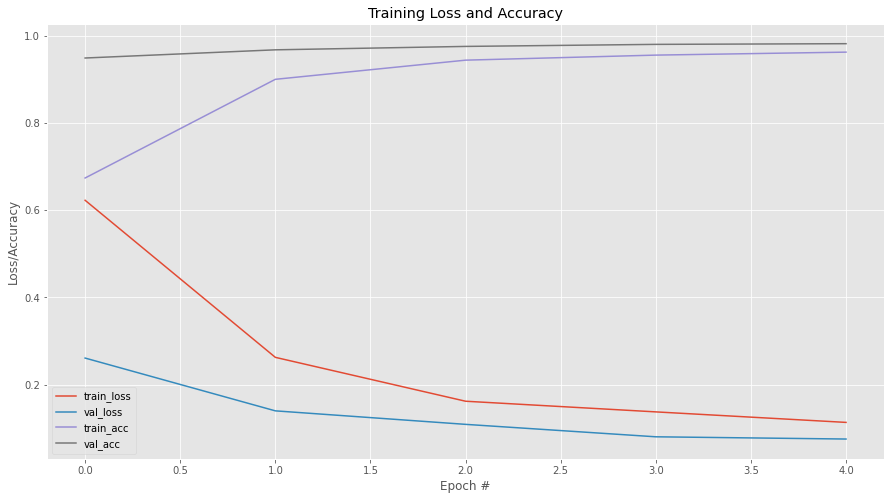

In [50]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure(figsize=(15,8))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

#code for prediction

In [48]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  print(np.argmax(classes))

Saving pic3.jpg to pic3 (1).jpg
[0.38032904 0.619671  ]
1
